# Early fusion: Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/'
output_path = '../out/aus_gemaps/'
# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load, prepare, and fuse data

#### Load

In [4]:
train_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_train.csv'))
train_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'gemaps', 'audio_data_gemaps_train.csv'))

In [5]:
train_video_df

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,actor_id,file_id,target,group
0,0.130612,0.240045,0.0,0.000000,0.238713,0.238713,0.250000,0.141816,0.451565,0.0,...,0.363398,0.0,0.007299,0.092857,0.092857,0.258065,1,0,1,4
1,0.044369,0.260825,0.0,0.009934,0.095937,0.095937,0.142857,0.069400,0.354630,0.0,...,0.584047,0.0,0.007299,0.057143,0.057143,0.161290,1,1,1,4
2,0.064720,0.237358,0.0,0.009934,0.110045,0.110045,0.285714,0.117179,0.324758,0.0,...,0.380347,0.0,0.029197,0.039286,0.039286,0.096774,1,2,1,4
3,0.102294,0.225245,0.0,0.000000,0.173815,0.173815,0.071429,0.068794,0.339125,0.0,...,0.303059,0.0,0.014599,0.035714,0.035714,0.129032,1,3,1,4
4,0.122895,0.296350,0.0,0.000000,0.174379,0.174379,0.178571,0.126430,0.469950,0.0,...,0.255539,0.0,0.058394,0.064286,0.064286,0.225806,1,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.051192,0.192379,0.0,0.026490,0.081264,0.081264,0.321429,0.093234,0.390645,0.0,...,0.358930,0.0,0.000000,0.569286,0.569286,0.161290,10,1255,17,5
1255,0.026198,0.275834,0.0,0.009934,0.028217,0.028217,0.535714,0.050406,0.353327,0.0,...,0.507585,0.0,0.021898,0.107143,0.107143,0.258065,10,1256,17,5
1256,0.081445,0.338825,0.0,0.003311,0.079007,0.079007,0.464286,0.118401,0.490531,0.0,...,0.551471,0.0,0.007299,0.078571,0.078571,0.322581,10,1257,17,5
1257,0.042385,0.270673,0.0,0.004967,0.070542,0.070542,0.214286,0.047610,0.394670,0.0,...,0.358960,0.0,0.000000,0.328571,0.328571,0.225806,10,1258,17,5


In [6]:
train_video_df.actor_id.value_counts()

10    126
9     126
8     126
7     126
6     126
4     126
3     126
2     126
1     126
5     125
Name: actor_id, dtype: int64

In [7]:
train_audio_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,actor_id,file_id,target,group
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.718996,0.330578,0.037114,0.117179,0.047826,0.088380,1,0,1,4
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.792587,0.264558,0.055237,0.089090,0.057971,0.000000,1,1,1,4
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.611349,0.344937,0.038350,0.090084,0.050725,0.049834,1,2,1,4
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.661599,0.337101,0.039662,0.074729,0.045894,0.040150,1,3,1,4
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.602913,0.161629,0.090247,0.320940,0.045894,0.058668,1,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.455030,0.051548,0.459465,0.432665,0.428898,0.042556,0.136981,0.009610,0.209519,0.008897,...,0.456192,0.192274,0.065019,0.064878,0.086957,0.127309,10,1255,17,5
1255,0.220083,0.513768,0.031770,0.317742,0.347561,0.422764,0.358086,0.306875,0.228330,0.014988,...,0.193118,0.396111,0.023316,0.090696,0.077122,0.096082,10,1256,17,5
1256,0.270762,0.520014,0.024084,0.363869,0.372689,0.462329,0.259245,0.118235,0.245574,0.060586,...,0.183356,0.376332,0.022740,0.107705,0.091938,0.147996,10,1257,17,5
1257,0.450948,0.089263,0.419079,0.440764,0.442042,0.104093,0.162826,0.065396,0.205408,0.005887,...,0.317359,0.155720,0.063989,0.077539,0.134058,0.268334,10,1258,17,5


In [8]:
train_audio_df.actor_id.value_counts()

10    126
9     126
8     126
7     126
6     126
4     126
3     126
2     126
1     126
5     125
Name: actor_id, dtype: int64

#### Fuse data

In [9]:
# Fuse training data (audio + video)
train_audio_id_df_tmp = train_audio_df.drop(columns=['target','actor_id','group'])              # Drop target, actor_id, and group from the audio dataframe, since they are already in the video dataframe
train_df = train_audio_id_df_tmp.merge(train_video_df, how='left', on='file_id')                # Merge on file_id
train_df = train_df[[c for c in train_df if c not in ['file_id', 'actor_id', 'group','target']]
                    + ['file_id', 'actor_id', 'group','target']]                                # Reorder columns so file_id, actor_id, and target are at the end of the dataframe
train_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,file_id,actor_id,group,target
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.363398,0.0,0.007299,0.092857,0.092857,0.258065,0,1,4,1
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.584047,0.0,0.007299,0.057143,0.057143,0.161290,1,1,4,1
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.380347,0.0,0.029197,0.039286,0.039286,0.096774,2,1,4,1
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.303059,0.0,0.014599,0.035714,0.035714,0.129032,3,1,4,1
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.255539,0.0,0.058394,0.064286,0.064286,0.225806,4,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.455030,0.051548,0.459465,0.432665,0.428898,0.042556,0.136981,0.009610,0.209519,0.008897,...,0.358930,0.0,0.000000,0.569286,0.569286,0.161290,1255,10,5,17
1255,0.220083,0.513768,0.031770,0.317742,0.347561,0.422764,0.358086,0.306875,0.228330,0.014988,...,0.507585,0.0,0.021898,0.107143,0.107143,0.258065,1256,10,5,17
1256,0.270762,0.520014,0.024084,0.363869,0.372689,0.462329,0.259245,0.118235,0.245574,0.060586,...,0.551471,0.0,0.007299,0.078571,0.078571,0.322581,1257,10,5,17
1257,0.450948,0.089263,0.419079,0.440764,0.442042,0.104093,0.162826,0.065396,0.205408,0.005887,...,0.358960,0.0,0.000000,0.328571,0.328571,0.225806,1258,10,5,17


#### Shuffle data

In [10]:
from sklearn.utils import shuffle

train_shuffled_df = shuffle(train_df, random_state=seed)
train_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,file_id,actor_id,group,target
315,0.240379,0.614553,0.089265,0.219347,0.284260,0.280270,0.303624,0.200022,0.262954,0.033284,...,0.304999,0.0,0.043796,0.065714,0.065714,0.354839,315,3,3,9
1116,0.428243,0.121044,0.397641,0.397569,0.437531,0.122617,0.148100,0.015786,0.218510,0.011256,...,0.516488,0.0,0.007299,0.057143,0.057143,0.096774,1117,9,4,15
986,0.499724,0.243378,0.437738,0.420981,0.586214,0.260613,0.142826,0.018867,0.205943,0.003317,...,0.360287,0.0,0.036496,0.053571,0.053571,0.258065,987,8,5,14
1066,0.294653,0.605192,0.026334,0.314250,0.475608,0.586494,0.137131,0.002755,0.226926,0.000000,...,0.539384,0.0,0.021898,0.062857,0.062857,0.161290,1067,9,4,9
323,0.154184,0.620439,0.076768,0.134368,0.172950,0.157283,0.179695,0.035599,0.277163,0.124323,...,0.384070,0.0,0.014599,0.054286,0.054286,0.354839,323,3,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.800665,0.175227,0.745947,0.790104,0.808547,0.188162,0.173931,0.011665,0.205735,0.023853,...,0.468963,0.0,0.007299,0.045714,0.045714,0.161290,141,2,1,3
1048,0.339490,0.457571,0.146215,0.395539,0.453824,0.425043,0.180069,0.018150,0.230690,0.016112,...,0.380418,0.0,0.000000,0.318571,0.318571,0.129032,1049,9,4,6
752,0.628904,0.354822,0.665858,0.633961,0.696183,0.139788,0.381234,0.154791,0.274983,0.100322,...,0.272443,0.0,0.051095,0.046429,0.046429,0.354839,753,6,2,17
543,0.663620,0.149773,0.618283,0.661143,0.654561,0.141982,0.142250,0.015549,0.208364,0.004063,...,0.355894,0.0,0.036496,0.102143,0.102143,0.483871,543,5,3,6


#### Other functions

In [11]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([18,18])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))
    
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')        

## Early Fusion Pipelines

### Elastic Net

In [12]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_elastic_net_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_elastic_net.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_elastic_net.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 87.6min finished


SGDClassifier(alpha=0.0025, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.1, learning_rate='optimal', loss='log', max_iter=2500,
              n_iter_no_change=20, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=27, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
484,1.532940,0.037948,0.265126,0.016770,0.0025,balanced,0.1,log,2500,20,...,27,"{'alpha': 0.0025, 'class_weight': 'balanced', ...",0.893843,0.854121,0.852742,0.855794,0.843513,0.860003,0.017447,1
345,3.249578,0.170359,0.258365,0.019190,0.001,balanced,0.35,log,2500,50,...,27,"{'alpha': 0.001, 'class_weight': 'balanced', '...",0.893259,0.851100,0.859392,0.855729,0.839519,0.859800,0.018018,2
341,3.490800,0.214063,0.276708,0.027163,0.001,balanced,0.3,log,2500,50,...,27,"{'alpha': 0.001, 'class_weight': 'balanced', '...",0.891794,0.851813,0.859801,0.855872,0.839636,0.859783,0.017375,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9401198262698868
AUC_std (train): 0.0028715810098013973
AUC_avg (validation): 0.8600027102127121
AUC_std (validation): 0.01744744268480717


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


UAR_avg (train): 0.5893909754825246
UAR_std (train): 0.016872453494494444
UAR_avg (validation): 0.3086782861292665
UAR_std (validation): 0.04514055721156268


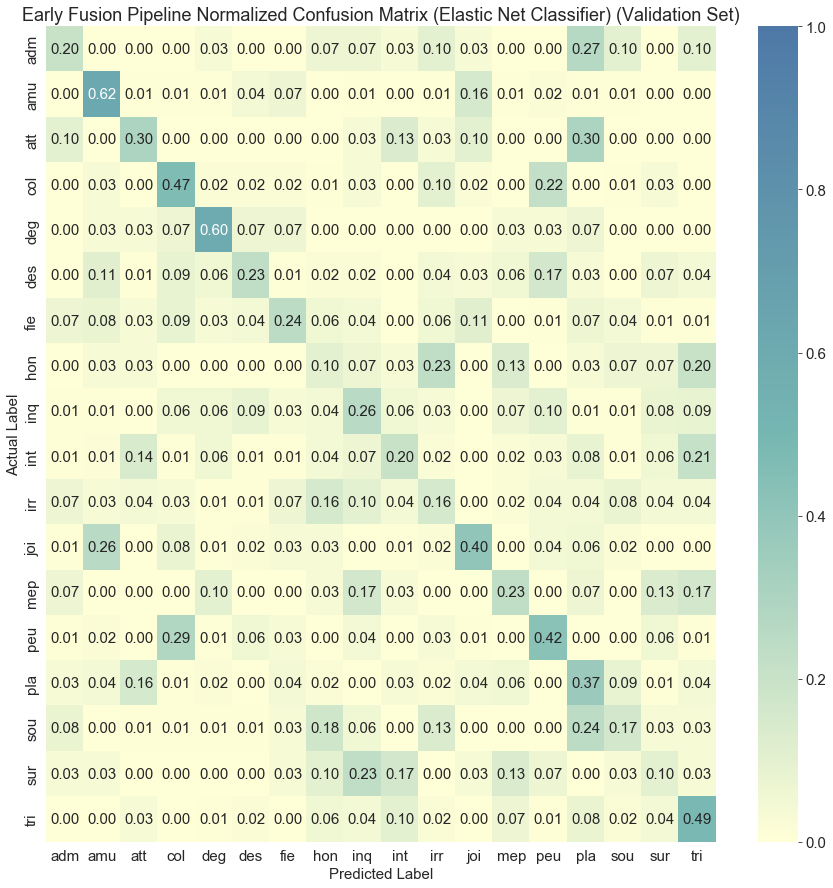

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_elastic_net.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Elastic Net Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_elastic_net.svg'
                     )

### kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_knn_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_knn.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_knn.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_tree.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 15.4min


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=286, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 8145 out of 8145 | elapsed: 17.3min finished


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1324,0.013765,0.000340,0.401812,0.039579,kd_tree,20,manhattan,-1,286,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 20, 'met...",0.870312,0.808383,0.814821,0.846632,0.802164,0.828463,0.025932,1
419,0.012322,0.002604,0.406972,0.023171,ball_tree,30,manhattan,-1,286,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.870312,0.808383,0.814821,0.846632,0.802164,0.828463,0.025932,1
781,0.006774,0.002178,0.474101,0.026886,brute,20,manhattan,-1,286,uniform,"{'algorithm': 'brute', 'leaf_size': 20, 'metri...",0.870312,0.808383,0.814821,0.846632,0.802164,0.828463,0.025932,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.8476504629309949
AUC_std (train): 0.007689849711129587
AUC_avg (validation): 0.8284625268052
AUC_std (validation): 0.02593217968458498


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


UAR_avg (train): 0.2596744044513998
UAR_std (train): 0.005273595346246289
UAR_avg (validation): 0.2372549019607843
UAR_std (validation): 0.026115634802096523


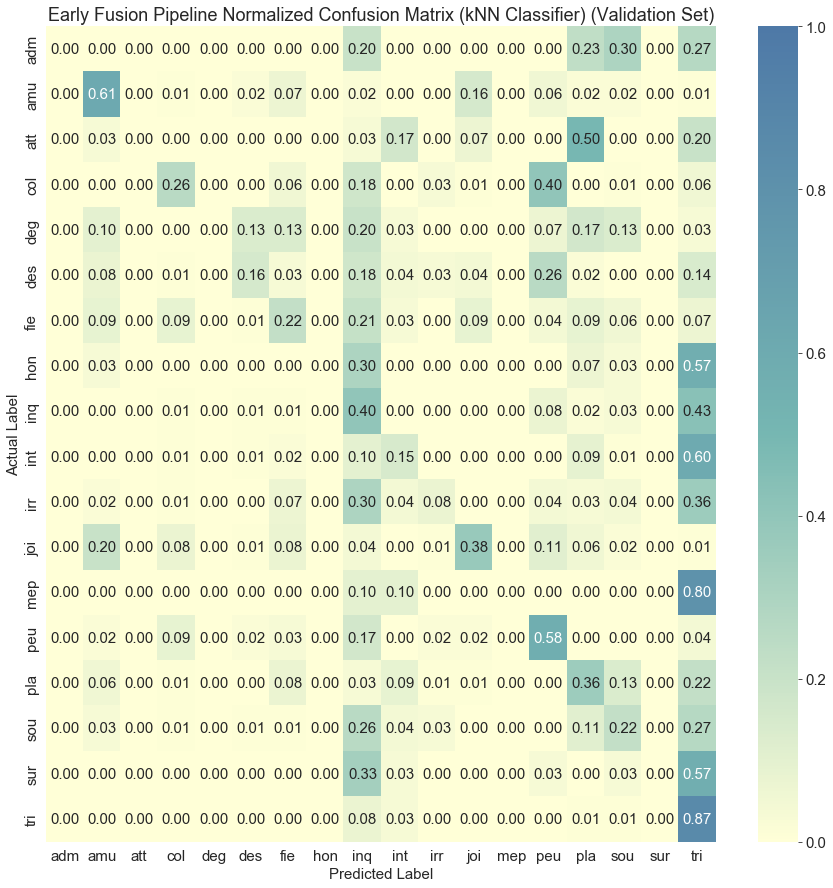

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_knn.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (kNN Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_knn.svg'
                     )

### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_tree_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_tree.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=30, max_features=53, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')


In [24]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3761,0.023918,0.000742,0.272980,0.002018,best,27,0.2,0.1,53,30,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.788477,0.726982,0.670625,0.742446,0.731948,0.732096,0.037658,1
3986,0.024559,0.001002,0.276709,0.005417,best,27,0.2,0.1,53,25,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.788477,0.726982,0.670625,0.742446,0.731948,0.732096,0.037658,1
2571,0.072950,0.004868,0.315003,0.027191,best,27,0.2,0.1,75,35,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.779172,0.727254,0.695172,0.727604,0.728538,0.731548,0.026960,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


AUC_avg (train): 0.7935807696753019
AUC_std (train): 0.012967843181873604
AUC_avg (validation): 0.7320955375266965
AUC_std (validation): 0.037658240457704995
UAR_avg (train): 0.2534602677795166
UAR_std (train): 0.014750495959535514
UAR_avg (validation): 0.21666666666666665
UAR_std (validation): 0.05389846901961252


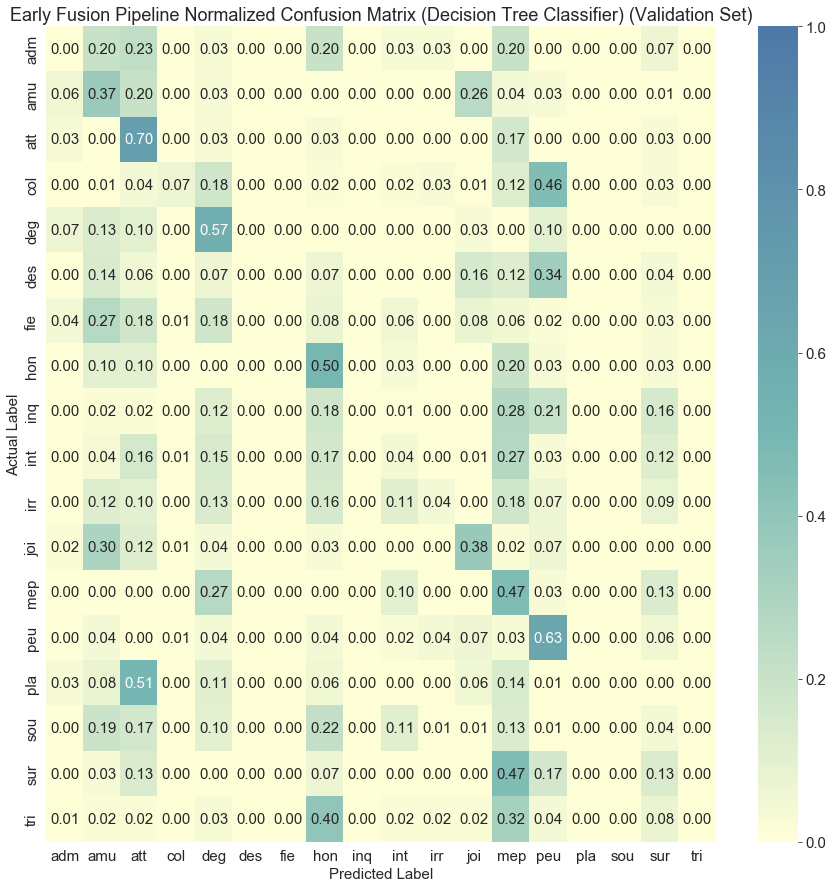

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_tree.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Decision Tree Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_tree.svg'
                     )

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_rf_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_rf.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_rf.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 70.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 87.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 104.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 123.6min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 144.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 165.9min
[Parallel(n_jobs=-1)]: Done 11242 tasks   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3305,7.389458,0.301210,1.004166,0.150241,27,-1,500,2,2,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.899847,0.842813,0.845367,0.851061,0.838404,0.855498,0.022549,1
1952,5.643270,0.064110,0.804759,0.066105,27,-1,495,2,2,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.899627,0.842930,0.845459,0.851022,0.838196,0.855447,0.022474,2
3063,5.804243,0.224703,0.764379,0.098350,27,-1,470,2,2,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.899406,0.843591,0.845040,0.850231,0.836913,0.855036,0.022588,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 1.0
AUC_std (train): 0.0
AUC_avg (validation): 0.855498281736811
AUC_std (validation): 0.02254897075227163


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


UAR_avg (train): 1.0
UAR_std (train): 0.0
UAR_avg (validation): 0.31176470588235294
UAR_std (validation): 0.0675156138051905


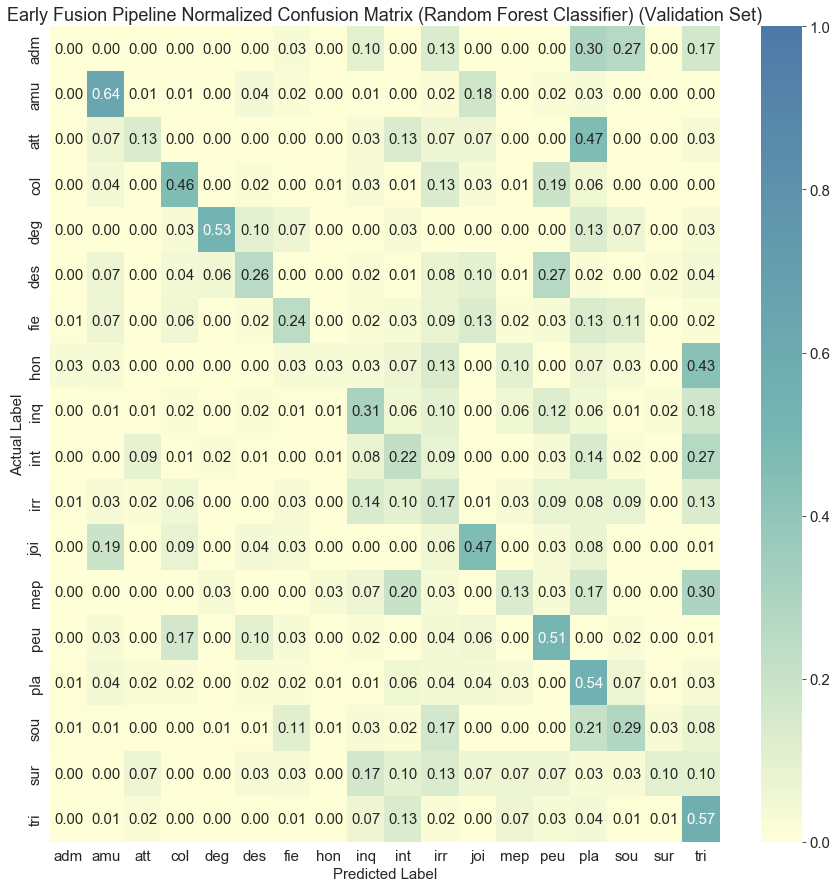

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_pipeline_early_fusion_clf_rf.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Random Forest Classifier) (Validation Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_rf.svg'
                     )